## Multi-Class Text Classification Using Deep Learning Algorithms

In [412]:
# Author : Abir Rahali <abirrahali2016@gmail.com>
# Date   : 13-11-2023

In [16]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns


# Text Processing Packages
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

In [3]:
print("STEP : Defining pre-processing parameters")

num_classes   = 5
max_len       = 900 
trunc_type    = 'post'
padding_type  = 'post'
oov_tok       = '<OOV>' # out of vocabulary token
vocab_size    = 1500
embedding_dim = 900
drop_value    = 0.2
n_dense       = 24
n_lstm        = 64
drop_lstm     = 0.5
num_epochs    = 5
opt           = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

STEP : Defining pre-processing parameters


In [5]:
print("STEP : Load the data files")
test_df = pd.read_csv("data/medical_tc_test.csv")
train_df = pd.read_csv('data/medical_tc_train.csv')


print("INFO : List of labels in the dataset")
print(train_df.condition_label.unique())


print("INFO : Shape of the train data")
print(train_df.shape)
print("INFO : Shape of the test data")
print(test_df.shape)

print("INFO : Example of the train data samples")
train_df.head()

STEP : Load the data files
INFO : List of labels in the dataset
[5 1 2 3 4]
INFO : Shape of the train data
(11550, 2)
INFO : Shape of the test data
(2888, 2)
INFO : Example of the train data samples


,condition_label,medical_abstract
0,5,Tissue changes around loose prostheses. A cani...
1,1,Neuropeptide Y and neuron-specific enolase lev...
2,2,"Sexually transmitted diseases of the colon, re..."
3,1,Lipolytic factors associated with murine and h...
4,3,Does carotid restenosis predict an increased r...


### Preprocessing Block: 

See Machine Learning Notebook (01) for full comments

In [7]:
# Data type change
train_df['text'] = train_df['medical_abstract'].astype(str)
test_df['text'] = test_df['medical_abstract'].astype(str)

# Remove rows with missing values
train_df.dropna(subset = ['text'], inplace = True)
test_df.dropna(subset = ['text'], inplace = True)

stop = stopwords.words('english')
porter = PorterStemmer()

def remove_punctuation(description):
    """The function to remove punctuation"""
    table = str.maketrans('', '', string.punctuation)
    return description.translate(table)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

train_df['text'] = train_df['text'].apply(remove_punctuation)
train_df['text'] = train_df['text'].apply(remove_stopwords)
train_df['text'] = train_df['text'].apply(stemmer)

test_df['text'] = test_df['text'].apply(remove_punctuation)
test_df['text'] = test_df['text'].apply(remove_stopwords)
test_df['text'] = test_df['text'].apply(stemmer)


train_df['length'] = train_df['text'].apply(len)
test_df['length'] = test_df['text'].apply(len)

print(train_df['length'].unique().mean())
print(test_df['length'].unique().mean())

train_df.head()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]
922.5533333333333
848.916451335056


,condition_label,medical_abstract,text,length
0,5,Tissue changes around loose prostheses. A cani...,tissu chang around loos prosthes canin model i...,649
1,1,Neuropeptide Y and neuron-specific enolase lev...,neuropeptid neuronspecif enolas level benign m...,760
2,2,"Sexually transmitted diseases of the colon, re...",sexual transmit diseas colon rectum anu challe...,1141
3,1,Lipolytic factors associated with murine and h...,lipolyt factor associ murin human cancer cache...,687
4,3,Does carotid restenosis predict an increased r...,carotid restenosi predict increas risk late sy...,954


For deep learning models we need a validate set to teach the algorithm, so we split the train into train and validate

In [9]:
print("STEP : Split the train data to train and validate to be used in the deep learning models")
x_train, x_validate, y_train, y_validate = train_test_split(train_df['text'], train_df['condition_label'], test_size=0.1, random_state=42)

print("STEP : Define the test X & Y")
x_test = test_df['text']
y_test = test_df['condition_label']

STEP : Split the train data to train and validate to be used in the deep learning models
STEP : Define the test X & Y


In [10]:
print("STEP : Encode the Y (label) in train, validate & test sets")
encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)

y_validate = encoder.transform(y_validate)
y_validate = tf.keras.utils.to_categorical(y_validate, num_classes)

y_test = encoder.transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

STEP : Encode the Y (label) in train, validate & test sets


For the tokenization we use basic tf.keras tokenizer

In [12]:
print("STEP : Create the tokenizer withe the train set and define the work index matrix")
tokenizer = Tokenizer(num_words = vocab_size, char_level = False, oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
total_words = len(word_index)

STEP : Create the tokenizer withe the train set and define the work index matrix


In [13]:
print("STEP : Create the train, validate & test tensors")

training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type)

validate_sequences = tokenizer.texts_to_sequences(x_validate)
validate_padded = pad_sequences(validate_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type)


print('INFO: Shape of training tensor: ', training_padded.shape)
print('INFO: Shape of validation tensor: ', validate_padded.shape)
print('INFO: Shape of testing tensor: ', testing_padded.shape)

STEP : Create the train, validate & test tensors
INFO: Shape of training tensor:  (10395, 900)
INFO: Shape of validation tensor:  (1155, 900)
INFO: Shape of testing tensor:  (2888, 900)


# I. Dense

In [14]:
print("STEP : Define Model 01 (Dense)")
model_01 = Sequential()
model_01.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model_01.add(GlobalAveragePooling1D())
model_01.add(Dense(16, activation='relu'))
model_01.add(Dense(64, activation='sigmoid'))
model_01.add(Dense(5, activation='sigmoid'))
model_01.compile(loss = 'categorical_crossentropy', optimizer = opt , metrics = ['accuracy'])

STEP : Define Model 01 (Dense)


In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model_01.fit(training_padded,
                    y_train,
                    epochs=100, 
                    validation_data=(validate_padded, y_validate),
                    callbacks =[early_stop],
                    verbose=1)

Epoch 1/100
325/325 [==============================] - 31s 93ms/step - loss: 1.3469 - accuracy: 0.4431 - val_loss: 1.2153 - val_accuracy: 0.4926
Epoch 2/100
325/325 [==============================] - 30s 91ms/step - loss: 1.1079 - accuracy: 0.5462 - val_loss: 1.0372 - val_accuracy: 0.5732
Epoch 3/100
325/325 [==============================] - 29s 88ms/step - loss: 0.9931 - accuracy: 0.5933 - val_loss: 0.9864 - val_accuracy: 0.5939
Epoch 4/100
325/325 [==============================] - 28s 88ms/step - loss: 0.9297 - accuracy: 0.6170 - val_loss: 1.0149 - val_accuracy: 0.5766
Epoch 5/100
325/325 [==============================] - 29s 89ms/step - loss: 0.8966 - accuracy: 0.6257 - val_loss: 0.9808 - val_accuracy: 0.5896
Epoch 6/100
325/325 [==============================] - 30s 91ms/step - loss: 0.8482 - accuracy: 0.6520 - val_loss: 0.9835 - val_accuracy: 0.6035
Epoch 7/100
325/325 [==============================] - 31s 96ms/step - loss: 0.8042 - accuracy: 0.6666 - val_loss: 1.0034 - val_ac

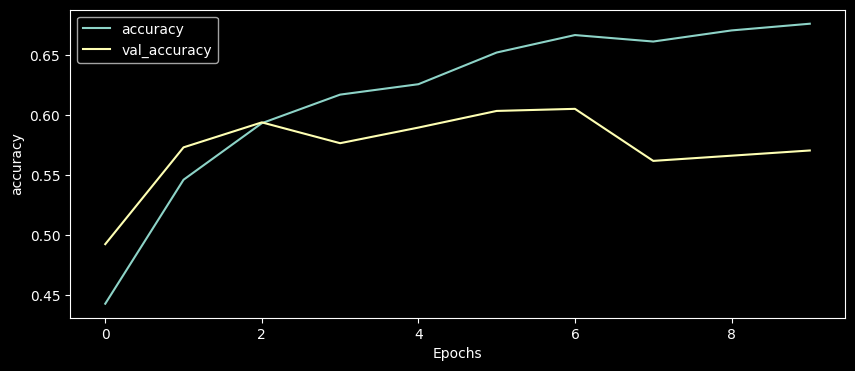

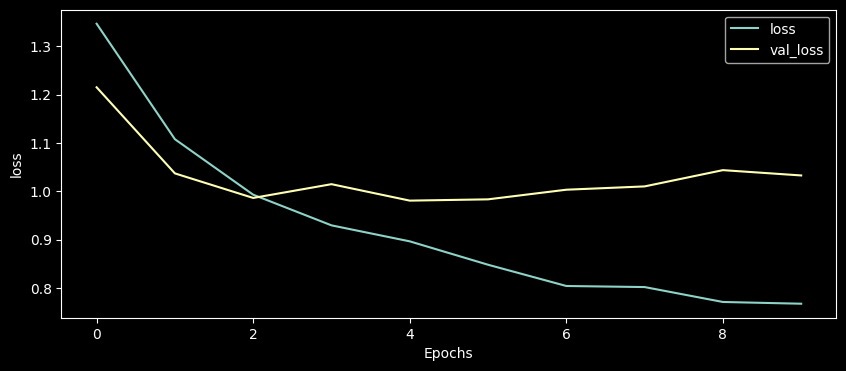

In [17]:
def plot_graphs(history, string):
    fig, ax = plt.subplots(figsize = (10, 4))
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [18]:
train_dense_results = model_01.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
test_dense_results = model_01.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {test_dense_results[1]*100:0.2f}')

41/41 - 10s - loss: 0.7107 - accuracy: 0.7021 - 10s/epoch - 236ms/step
12/12 - 3s - loss: 1.0403 - accuracy: 0.5748 - 3s/epoch - 236ms/step
Train accuracy: 70.21
Valid accuracy: 57.48


# II. LSTM

In [19]:
# Define LSTM Model 
model_02 = Sequential()
model_02.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model_02.add(SpatialDropout1D(drop_lstm))
model_02.add(LSTM(n_lstm, return_sequences=False))
model_02.add(Dropout(drop_lstm))
model_02.add(Dense(5, activation='sigmoid'))
model_02.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model_02.fit(training_padded,
                     y_train,
                     epochs=2, 
                     validation_data=(validate_padded, y_validate),
                     callbacks =[early_stop],
                     verbose=1)

Epoch 1/2
325/325 [==============================] - 392s 1s/step - loss: 1.5536 - accuracy: 0.3227 - val_loss: 1.5235 - val_accuracy: 0.3359
Epoch 2/2
325/325 [==============================] - 353s 1s/step - loss: 1.5405 - accuracy: 0.3281 - val_loss: 1.5254 - val_accuracy: 0.3359


In [402]:
train_dense_results = model_02.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
test_dense_results = model_02.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {test_dense_results[1]*100:0.2f}')

41/41 - 5s - loss: 1.5083 - accuracy: 0.3465 - 5s/epoch - 130ms/step
12/12 - 2s - loss: 1.5355 - accuracy: 0.3168 - 2s/epoch - 140ms/step
Train accuracy: 34.65
Valid accuracy: 31.68


# III. BILSTM

In [403]:
model_03 = Sequential()
model_03.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model_03.add(Bidirectional(LSTM(n_lstm, return_sequences = False)))
model_03.add(Dropout(drop_lstm))
model_03.add(Dense(5, activation='sigmoid'))
model_03.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [404]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)
history = model_03.fit(training_padded,
                     y_train,
                     epochs = num_epochs,
                     validation_data = (validate_padded, y_validate),
                     callbacks = [early_stop],
                     verbose = 1)

Epoch 1/5
325/325 [==============================] - 44s 127ms/step - loss: 1.6454 - accuracy: 0.3034 - val_loss: 1.5006 - val_accuracy: 0.3524
Epoch 2/5
325/325 [==============================] - 39s 120ms/step - loss: 1.5330 - accuracy: 0.3396 - val_loss: 1.4926 - val_accuracy: 0.3446
Epoch 3/5
325/325 [==============================] - 40s 124ms/step - loss: 1.5106 - accuracy: 0.3471 - val_loss: 1.4782 - val_accuracy: 0.3619
Epoch 4/5
325/325 [==============================] - 42s 129ms/step - loss: 1.4959 - accuracy: 0.3598 - val_loss: 1.4460 - val_accuracy: 0.3784
Epoch 5/5
325/325 [==============================] - 41s 125ms/step - loss: 1.4759 - accuracy: 0.3668 - val_loss: 1.4580 - val_accuracy: 0.3758


In [405]:
train_dense_results = model_03.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
test_dense_results = model_03.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {test_dense_results[1]*100:0.2f}')

41/41 - 10s - loss: 1.3981 - accuracy: 0.4056 - 10s/epoch - 249ms/step
12/12 - 3s - loss: 1.4670 - accuracy: 0.3587 - 3s/epoch - 272ms/step
Train accuracy: 40.56
Valid accuracy: 35.87


# Compaire

In [406]:
# Comparing the four different models

print(f"Dense model loss and accuracy: {model_01.evaluate(testing_padded, y_test)} " )
print(f"LSTM model loss and accuracy: {model_02.evaluate(testing_padded, y_test)} " )
print(f"Bi-LSTM model loss and accuracy: {model_03.evaluate(testing_padded, y_test)} " )

91/91 [==============================] - 0s 3ms/step - loss: 1.1082 - accuracy: 0.5533
Dense model loss and accuracy: [1.108203411102295, 0.5533241033554077] 
91/91 [==============================] - 3s 31ms/step - loss: 1.5355 - accuracy: 0.3168
LSTM model loss and accuracy: [1.5354512929916382, 0.31682825088500977] 
91/91 [==============================] - 5s 53ms/step - loss: 1.4670 - accuracy: 0.3587
Bi-LSTM model loss and accuracy: [1.4669564962387085, 0.35872575640678406] 


# Predict

In [40]:
new_abstract = ["Heart"]

categories_map = {
    1: "Neoplasms",
    2: "Digestive system diseases",
    3: "Nervous system diseases",
    4: "Cardiovascular diseases",
    5: "General pathological conditions",
}

def predict(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq,
                           maxlen = max_len,
                           padding = padding_type,
                           truncating = trunc_type)
    predicted_class = np.argmax(model_01.predict(padded)[0])+1
    category_name = categories_map[predicted_class]
    confidence = "%.2f" % (max(model_01.predict(padded)[0])*100) + "%"
    return category_name, confidence

category_name, confidence = predict(new_abstract)

print('\nPredicted Class -> {}'.format(category_name))
print('Prediction Confidence -> {}'.format(confidence))

1/1 [==============================] - 0s 25ms/step

Predicted Class -> Cardiovascular diseases
Prediction Confidence -> 63.93%


# Conclusion

In our efforts to enhance text classification models, the application of LSTM and BiLSTM architectures with basic Keras tokenization demonstrated limited improvement in predictive accuracy, primarily due to the constraint of small training epochs (due to time giving to finish this task) and the absence of substantial hyperparameter tuning. If more time invested better results can be achieved.